In [1]:
import pandas as pd
import numpy as np
from gensim.downloader import load as gensim_load
from sklearn.metrics.pairwise import cosine_similarity

# 0. Load pieman_segments
pieman_segments = pd.read_csv("pieman_segments.csv")

# 1. Load pretrained Word2Vec model
model = gensim_load("glove-wiki-gigaword-300")  # 300d

# 2. Define prototype words for each emotion
emotion_words = {
    "happiness": ["happy", "joy", "delighted", "pleased", "content", "excited"],
    "sadness": ["sad", "unhappy", "miserable", "depressed", "gloomy", "tearful"],
    "anger": ["angry", "mad", "furious", "irritated", "annoyed", "enraged"],
    "fear": ["afraid", "scared", "fearful", "terrified", "nervous", "anxious"],
    "surprise": ["surprised", "shocked", "astonished", "amazed", "startled", "stunned"],
    "disgust": ["disgusted", "repulsed", "gross", "nauseated", "revolted", "sickened"]
}

# 3. Compute prototype vectors
emotion_prototypes = {}
for emo, words in emotion_words.items():
    vecs = [model[w] for w in words if w in model]
    if vecs:
        emotion_prototypes[emo] = np.mean(vecs, axis=0)
    else:
        raise ValueError(f"No valid words found in model for emotion: {emo}")

# 4. Process your TR data
tmp = pieman_segments.copy()
tmp["word_raw"] = tmp["word_raw"].astype(str).str.lower()
tmp = tmp[tmp["word_raw"].notna() & tmp["word_raw"].str.len().gt(0)]

words_by_tr = tmp.groupby("TR", as_index=True)["word_raw"].apply(list).sort_index()

# 5. Get average vector per TR
def get_avg_vector(tokens):
    vecs = [model[w] for w in tokens if w in model]
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)

tr_embeddings = words_by_tr.apply(get_avg_vector)
tr_embed_df = pd.DataFrame(tr_embeddings.tolist(), index=tr_embeddings.index)
tr_embed_df = tr_embed_df.reset_index().rename(columns={i: f"dim_{i}" for i in range(model.vector_size)})

# 6. Compute cosine similarities with each emotion prototype
def cosine_sim(v1, v2):
    return cosine_similarity(v1.reshape(1, -1), v2.reshape(1, -1))[0][0]

for emo, proto_vec in emotion_prototypes.items():
    tr_embed_df[emo] = tr_embed_df[[f"dim_{i}" for i in range(model.vector_size)]].apply(
        lambda row: cosine_sim(row.to_numpy(), proto_vec), axis=1
    )

# 7. Rolling 2-TR trailing mean
all_tr = pd.DataFrame({"TR": np.arange(pieman_segments["TR"].min(), pieman_segments["TR"].max() + 1)})
tr_scores = all_tr.merge(tr_embed_df[["TR"] + list(emotion_prototypes.keys())], on="TR", how="left").fillna(0.0)

In [3]:
# Grab TR by TR for "happiness", "sadness", "anger", "fear", "surprise", "disgust" in TR_scores 
# Also make any rows without a TR (e.g. if we go from 16 to 18 in the TR column) exist and grabbing the previous rows scores for the 6 emo variables
# Train HMM for 2, 3, 4, 5, 6, 7, 8, 9, 10 states (based on the 6 emo variables) and compute log likelihood for each number of states
# Save TR by state csv for best fitting model (BIC)

In [15]:
tr_scores_filled = tr_scores.copy()
tr_scores_filled[list(emotion_prototypes.keys())] = (
    tr_scores_filled[list(emotion_prototypes.keys())]
    .replace(0.0, np.nan)  # Treat 0s as missing
    .ffill()               # Forward-fill missing rows
    .fillna(0.0)           # In case first row is missing
)

In [27]:
from hmmlearn.hmm import GaussianHMM
import time

# 9. Prepare data for HMM
X = tr_scores_filled[emotion_prototypes.keys()].to_numpy()
n_samples, n_features = X.shape

# 10. Fit HMMs for 2 to 10 states, calculate BIC
models = {}
bics = []
log_likelihoods = []

def compute_num_parameters(n_states, n_features):
    p_init  = n_states - 1
    p_trans = n_states * (n_states - 1)
    p_means = n_states * n_features
    p_cov   = n_states * (n_features * (n_features + 1) // 2)
    return p_init + p_trans + p_means + p_cov

for n_states in range(2, 15):
    
    print("Running for State: ", n_states)
    model = GaussianHMM(n_components=n_states, covariance_type="full", random_state=50, n_iter=100, verbose=True)
    model.fit(X)

    logL = model.score(X)
    n_params = compute_num_parameters(n_states, 6)
    bic = -2 * logL + n_params * np.log(n_samples)

    models[n_states] = model
    log_likelihoods.append(logL)
    bics.append(bic)

    time.sleep(2)

Running for State:  2


         1    2479.86646559             +nan
         2    2671.69944234    +191.83297675
         3    2695.00351026     +23.30406792
         4    2707.10748162     +12.10397136
         5    2719.58905676     +12.48157514
         6    2732.68489349     +13.09583673
         7    2738.68525849      +6.00036501
         8    2741.89327424      +3.20801575
         9    2744.09347664      +2.20020240
        10    2745.82565118      +1.73217454
        11    2747.28778253      +1.46213135
        12    2748.47741875      +1.18963622
        13    2749.32464140      +0.84722265
        14    2749.84522615      +0.52058475
        15    2750.13103272      +0.28580657
        16    2750.27940675      +0.14837403
        17    2750.35732055      +0.07791381
        18    2750.40132189      +0.04400134
        19    2750.42898586      +0.02766397
        20    2750.44831426      +0.01932840
        21    2750.46293302      +0.01461875
        22    2750.47454184      +0.01160882
        23

Running for State:  3


         1    2488.51048141             +nan
         2    2705.28853098    +216.77804957
         3    2740.32928769     +35.04075671
         4    2758.27759086     +17.94830317
         5    2766.99693483      +8.71934397
         6    2770.58326167      +3.58632684
         7    2772.59111860      +2.00785693
         8    2774.58569984      +1.99458123
         9    2777.00045163      +2.41475180
        10    2778.52263297      +1.52218134
        11    2779.34155094      +0.81891797
        12    2779.92942426      +0.58787332
        13    2780.43015105      +0.50072678
        14    2780.88128332      +0.45113227
        15    2781.28149495      +0.40021163
        16    2781.62160500      +0.34011005
        17    2781.89917577      +0.27757076
        18    2782.12027867      +0.22110291
        19    2782.29478002      +0.17450134
        20    2782.43244722      +0.13766721
        21    2782.54154126      +0.10909403
        22    2782.62863549      +0.08709424
        23

Running for State:  4


         1    2502.51568989             +nan
         2    2719.31600228    +216.80031239
         3    2752.02218042     +32.70617814
         4    2766.91927123     +14.89709081
         5    2778.50270751     +11.58343627
         6    2787.13241424      +8.62970673
         7    2795.89735936      +8.76494512
         8    2805.05715000      +9.15979064
         9    2812.31386905      +7.25671905
        10    2817.98941848      +5.67554943
        11    2823.15472774      +5.16530926
        12    2827.87110060      +4.71637285
        13    2831.44802019      +3.57691959
        14    2835.16437598      +3.71635580
        15    2840.85875608      +5.69438010
        16    2843.08511170      +2.22635562
        17    2844.27672660      +1.19161490
        18    2845.41597622      +1.13924962
        19    2846.33289173      +0.91691551
        20    2847.37645735      +1.04356562
        21    2850.18040992      +2.80395258
        22    2852.15593638      +1.97552646
        23

Running for State:  5


         1    2456.27745613             +nan
         2    2715.80472372    +259.52726759
         3    2761.15615062     +45.35142690
         4    2784.50190410     +23.34575348
         5    2798.64573231     +14.14382822
         6    2810.21921850     +11.57348619
         7    2821.86066171     +11.64144321
         8    2831.14288417      +9.28222246
         9    2839.32718883      +8.18430466
        10    2846.32888397      +7.00169514
        11    2855.78827968      +9.45939570
        12    2871.51968532     +15.73140565
        13    2879.31098873      +7.79130341
        14    2882.76682889      +3.45584016
        15    2884.33995030      +1.57312141
        16    2885.40473142      +1.06478112
        17    2886.94644779      +1.54171638
        18    2890.36454597      +3.41809817
        19    2891.73685055      +1.37230458
        20    2892.31363744      +0.57678689
        21    2892.55127657      +0.23763913
        22    2892.74536886      +0.19409229
        23

Running for State:  6


         1    2459.20919150             +nan
         2    2702.18695208    +242.97776058
         3    2750.58483202     +48.39787994
         4    2776.71842349     +26.13359147
         5    2793.42162782     +16.70320433
         6    2806.20643340     +12.78480559
         7    2819.11823723     +12.91180382
         8    2831.17732560     +12.05908837
         9    2837.63457350      +6.45724790
        10    2843.37168683      +5.73711333
        11    2846.81882805      +3.44714122
        12    2849.28545054      +2.46662249
        13    2851.13622993      +1.85077939
        14    2852.51890449      +1.38267455
        15    2853.77495562      +1.25605113
        16    2855.09864110      +1.32368549
        17    2856.45782591      +1.35918481
        18    2857.69476460      +1.23693868
        19    2858.89489615      +1.20013156
        20    2860.15723905      +1.26234290
        21    2861.44744664      +1.29020758
        22    2862.48081104      +1.03336440
        23

Running for State:  7


         1    2487.67700088             +nan
         2    2741.29316640    +253.61616552
         3    2794.55090110     +53.25773469
         4    2840.02911776     +45.47821666
         5    2861.71746073     +21.68834297
         6    2881.04573286     +19.32827213
         7    2936.68930385     +55.64357099
         8    2888.86994022     -47.81936364
Model is not converging.  Current: 2888.869940217701 is not greater than 2936.6893038535754. Delta is -47.81936363587465


Running for State:  8


         1    2490.68765271             +nan
         2    2730.33065763    +239.64300492
         3    2797.50658122     +67.17592358
         4    2850.96587330     +53.45929209
         5    2883.37122611     +32.40535281
         6    2891.38918570      +8.01795960
         7    2895.92345159      +4.53426588
         8    2900.05266784      +4.12921625
         9    2905.38462542      +5.33195758
        10    2908.14853873      +2.76391331
        11    2909.94616902      +1.79763029
        12    2913.10615417      +3.15998515
        13    2918.46364963      +5.35749546
        14    2922.53539583      +4.07174620
        15    2923.63553695      +1.10014112
        16    2923.80837416      +0.17283721
        17    2923.93960881      +0.13123465
        18    2924.12428483      +0.18467602
        19    2924.41548571      +0.29120089
        20    2924.83738533      +0.42189962
        21    2925.41468708      +0.57730175
        22    2926.30790343      +0.89321635
        23

Running for State:  9


         1    2407.79965771             +nan
         2    2721.72306707    +313.92340936
         3    2779.78345774     +58.06039067
         4    2811.78880972     +32.00535198
         5    2838.70755793     +26.91874821
         6    2862.75080620     +24.04324827
         7    2883.74275357     +20.99194736
         8    2905.54235233     +21.79959877
         9    2924.83727409     +19.29492176
        10    2936.67653665     +11.83926256
        11    2941.11087308      +4.43433643
        12    2943.13363088      +2.02275780
        13    2944.80478586      +1.67115498
        14    2947.48808852      +2.68330267
        15    2951.49106944      +4.00298091
        16    2953.92860328      +2.43753385
        17    2955.91094674      +1.98234346
        18    2958.70762798      +2.79668124
        19    2962.58549160      +3.87786362
        20    2965.44352929      +2.85803769
        21    2967.22355555      +1.78002626
        22    2969.16888510      +1.94532955
        23

Running for State:  10


         1    2437.39816702             +nan
         2    2762.13488910    +324.73672208
         3    2848.62021353     +86.48532443
         4    2928.53172609     +79.91151256
         5    2975.61740591     +47.08567982
         6    3012.72963078     +37.11222487
         7    3028.68020659     +15.95057580
         8    3032.54525502      +3.86504844
         9    3034.37635769      +1.83110266
        10    3036.35881468      +1.98245699
        11    3037.96671446      +1.60789978
        12    3038.53709652      +0.57038206
        13    3039.28471644      +0.74761992
        14    3040.84168359      +1.55696714
        15    3043.23854970      +2.39686611
        16    3044.34205405      +1.10350435
        17    3044.57360493      +0.23155088
        18    3044.62934681      +0.05574188
        19    3044.64842900      +0.01908219
        20    3044.67597771      +0.02754871
        21    3044.74395428      +0.06797657
        22    3044.91534438      +0.17139010
        23

Running for State:  11


         1    2418.90591941             +nan
         2    2737.81451487    +318.90859546
         3    2841.81223058    +103.99771571
         4    2896.94024559     +55.12801501
         5    2929.83664914     +32.89640356
         6    2949.73128009     +19.89463094
         7    2958.29980782      +8.56852773
         8    2962.89606318      +4.59625537
         9    2966.53650588      +3.64044269
        10    2971.84328933      +5.30678345
        11    2977.16905980      +5.32577047
        12    2981.20582463      +4.03676484
        13    2984.86422756      +3.65840293
        14    2988.19025971      +3.32603215
        15    2989.27048500      +1.08022529
        16    2989.86617719      +0.59569220
        17    2990.49407527      +0.62789807
        18    2991.55212850      +1.05805323
        19    2992.84311927      +1.29099077
        20    2994.27982530      +1.43670603
        21    2994.90222767      +0.62240237
        22    2995.97130224      +1.06907457
        23

Running for State:  12


         1    2459.67180885             +nan
         2    2782.16317167    +322.49136282
         3    2871.70539386     +89.54222219
         4    2946.64227927     +74.93688541
         5    3013.58841425     +66.94613498
         6    3032.72857931     +19.14016506
         7    3046.72772487     +13.99914556
         8    3147.35200649    +100.62428162
         9    3061.03932082     -86.31268567
Model is not converging.  Current: 3061.03932081978 is not greater than 3147.352006491369. Delta is -86.31268567158895


Running for State:  13


         1    2386.81460437             +nan
         2    2777.51400166    +390.69939729
         3    2865.40295206     +87.88895040
         4    2938.44758197     +73.04462991
         5    3001.87228729     +63.42470531
         6    3071.23619697     +69.36390968
         7    3100.94256764     +29.70637067
         8    3118.48466110     +17.54209347
         9    3152.72622193     +34.24156082
        10    3075.01840458     -77.70781734
Model is not converging.  Current: 3075.0184045836572 is not greater than 3152.7262219262975. Delta is -77.70781734264028


Running for State:  14


         1    2383.35136641             +nan
         2    2762.51874464    +379.16737823
         3    2865.36712182    +102.84837718
         4    2950.92500046     +85.55787864
         5    3105.14590821    +154.22090775
         6    3159.12153559     +53.97562738
         7    3144.75739034     -14.36414524
Model is not converging.  Current: 3144.7573903441285 is not greater than 3159.121535588496. Delta is -14.364145244367592


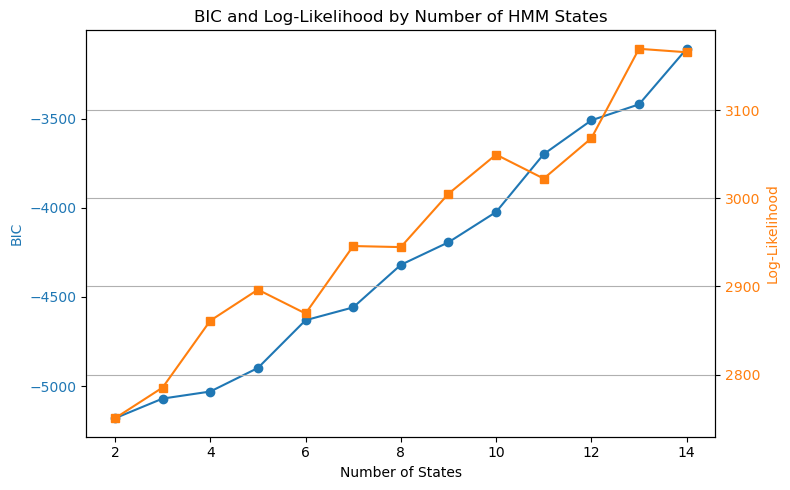

In [28]:
import matplotlib.pyplot as plt

states_tested = list(range(2, len(bics) + 2))

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot BIC on left y-axis
color_bic = 'tab:blue'
ax1.set_xlabel("Number of States")
ax1.set_ylabel("BIC", color=color_bic)
ax1.plot(states_tested, bics, marker='o', color=color_bic, label="BIC")
ax1.tick_params(axis='y', labelcolor=color_bic)

# Create right y-axis for log-likelihood
ax2 = ax1.twinx()
color_ll = 'tab:orange'
ax2.set_ylabel("Log-Likelihood", color=color_ll)
ax2.plot(states_tested, log_likelihoods, marker='s', color=color_ll, label="Log-Likelihood")
ax2.tick_params(axis='y', labelcolor=color_ll)

# Title and grid
plt.title("BIC and Log-Likelihood by Number of HMM States")
fig.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
# 11. Select best model by BIC
best_n = range(2, 11)[np.argmin(bics)]
best_model = models[best_n]
print(f"Best model: {best_n} states (BIC = {min(bics):.2f})")

# 12. Predict state sequence
state_sequence = best_model.predict(X)

# 13. Save TR-by-state DataFrame
tr_state_df = tr_scores_filled[["TR"]].copy()
tr_state_df["State"] = state_sequence
tr_state_df.to_csv("pieman_tr_by_state.csv", index=False)